In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [3]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from sklearn.preprocessing import LabelEncoder

import os
import re
import requests

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_dir = '../Dataset/train_images'
test_dir = '../Dataset/test_images'
train_csv = '../Dataset/train.csv'
test_csv = '../Dataset/test.csv'
sample_submission = '../Dataset/sample_submission.csv'
cat_attr = '../Dataset/category_attributes.parquet'

In [5]:
model_category = 'Men Tshirts'

In [6]:
train_df = pd.read_csv(train_csv)
train_df

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10
0,0,Men Tshirts,5,default,round,printed,default,short sleeves,NaN,NaN,NaN,NaN,NaN
1,1,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
2,2,Men Tshirts,5,default,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
3,3,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
4,4,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70208,70374,Women Tops & Tunics,10,multicolor,fitted,regular,square neck,casual,printed,default,short sleeves,regular sleeves,ruffles
70209,70375,Women Tops & Tunics,10,yellow,regular,crop,round neck,casual,default,default,short sleeves,regular sleeves,knitted
70210,70376,Women Tops & Tunics,10,maroon,fitted,crop,round neck,casual,solid,solid,short sleeves,regular sleeves,knitted
70211,70377,Women Tops & Tunics,10,NaN,NaN,NaN,high,NaN,NaN,NaN,short sleeves,NaN,NaN


In [ ]:
train_df_cat = train_df[train_df['Category'] == model_category]
n = 10 - (train_df_cat['len'].values[0])
if (n != 0):
    train_df_cat.drop(columns=train_df_cat.columns[-n:], axis=1, inplace=True)
# train_df_cat.drop(["attr_6","attr_7","attr_8","attr_9","attr_10"], axis =1, inplace = True)
train_df_cat

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5
0,0,Men Tshirts,5,default,round,printed,default,short sleeves
1,1,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves
2,2,Men Tshirts,5,default,polo,solid,solid,short sleeves
3,3,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves
4,4,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves
...,...,...,...,...,...,...,...,...
7262,7424,Men Tshirts,5,NaN,NaN,printed,NaN,NaN
7263,7425,Men Tshirts,5,NaN,round,NaN,NaN,NaN
7264,7426,Men Tshirts,5,NaN,NaN,NaN,default,short sleeves
7265,7429,Men Tshirts,5,NaN,NaN,NaN,default,NaN


In [8]:
cat_attr_df = pd.read_parquet(cat_attr)
pd.set_option('display.max_colwidth', None)
cat_attr_df

,Category,No_of_attribute,Attribute_list
0,Men Tshirts,5,"[color, neck, pattern, print_or_pattern_type, sleeve_length]"
1,Sarees,10,"[blouse_pattern, border, border_width, color, occasion, ornamentation, pallu_details, pattern, print_or_pattern_type, transparency]"
2,Kurtis,9,"[color, fit_shape, length, occasion, ornamentation, pattern, print_or_pattern_type, sleeve_length, sleeve_styling]"
3,Women Tshirts,8,"[color, fit_shape, length, pattern, print_or_pattern_type, sleeve_length, sleeve_styling, surface_styling]"
4,Women Tops & Tunics,10,"[color, fit_shape, length, neck_collar, ocassion, pattern, print_or_pattern_type, sleeve_length, sleeve_styling, surface_styling]"


In [ ]:
# Step 1: Extract the attribute list for "Men Tshirts" from cat_attr_df
men_tshirts_attributes = cat_attr_df.loc[cat_attr_df['Category'] == model_category, 'Attribute_list'].values[0]

# Step 2: Create a mapping for the columns
# Assuming attr_1 corresponds to the first item in Attribute_list, attr_2 to the second, etc.
attr_columns = train_df_cat.filter(like='attr_').columns.to_list() # Adjust if more attributes exist
print(attr_columns)
rename_dict = {f'attr_{i+1}': men_tshirts_attributes[i] for i in range(len(attr_columns))}

# Step 3: Rename the columns in Men_Tshirts_df
# train_df_cat.rename(columns=rename_dict, inplace=True)

# Now you can print or check the updated DataFrame
train_df_cat

['attr_1', 'attr_2', 'attr_3', 'attr_4', 'attr_5']


,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5
0,0,Men Tshirts,5,default,round,printed,default,short sleeves
1,1,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves
2,2,Men Tshirts,5,default,polo,solid,solid,short sleeves
3,3,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves
4,4,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves
...,...,...,...,...,...,...,...,...
7262,7424,Men Tshirts,5,NaN,NaN,printed,NaN,NaN
7263,7425,Men Tshirts,5,NaN,round,NaN,NaN,NaN
7264,7426,Men Tshirts,5,NaN,NaN,NaN,default,short sleeves
7265,7429,Men Tshirts,5,NaN,NaN,NaN,default,NaN


In [ ]:
def format_image_path(row):
    return f"../Dataset/train_images/{str(row['id']).zfill(6)}.jpg"

# Add the new column 'image_path' using the formatted id
train_df_cat['image_path'] = train_df_cat.apply(format_image_path, axis=1)
train_df_cat

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,image_path
0,0,Men Tshirts,5,default,round,printed,default,short sleeves,/kaggle/input/visual-taxonomy/train_images/000000.jpg
1,1,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,/kaggle/input/visual-taxonomy/train_images/000001.jpg
2,2,Men Tshirts,5,default,polo,solid,solid,short sleeves,/kaggle/input/visual-taxonomy/train_images/000002.jpg
3,3,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,/kaggle/input/visual-taxonomy/train_images/000003.jpg
4,4,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,/kaggle/input/visual-taxonomy/train_images/000004.jpg
...,...,...,...,...,...,...,...,...,...
7262,7424,Men Tshirts,5,NaN,NaN,printed,NaN,NaN,/kaggle/input/visual-taxonomy/train_images/007424.jpg
7263,7425,Men Tshirts,5,NaN,round,NaN,NaN,NaN,/kaggle/input/visual-taxonomy/train_images/007425.jpg
7264,7426,Men Tshirts,5,NaN,NaN,NaN,default,short sleeves,/kaggle/input/visual-taxonomy/train_images/007426.jpg
7265,7429,Men Tshirts,5,NaN,NaN,NaN,default,NaN,/kaggle/input/visual-taxonomy/train_images/007429.jpg


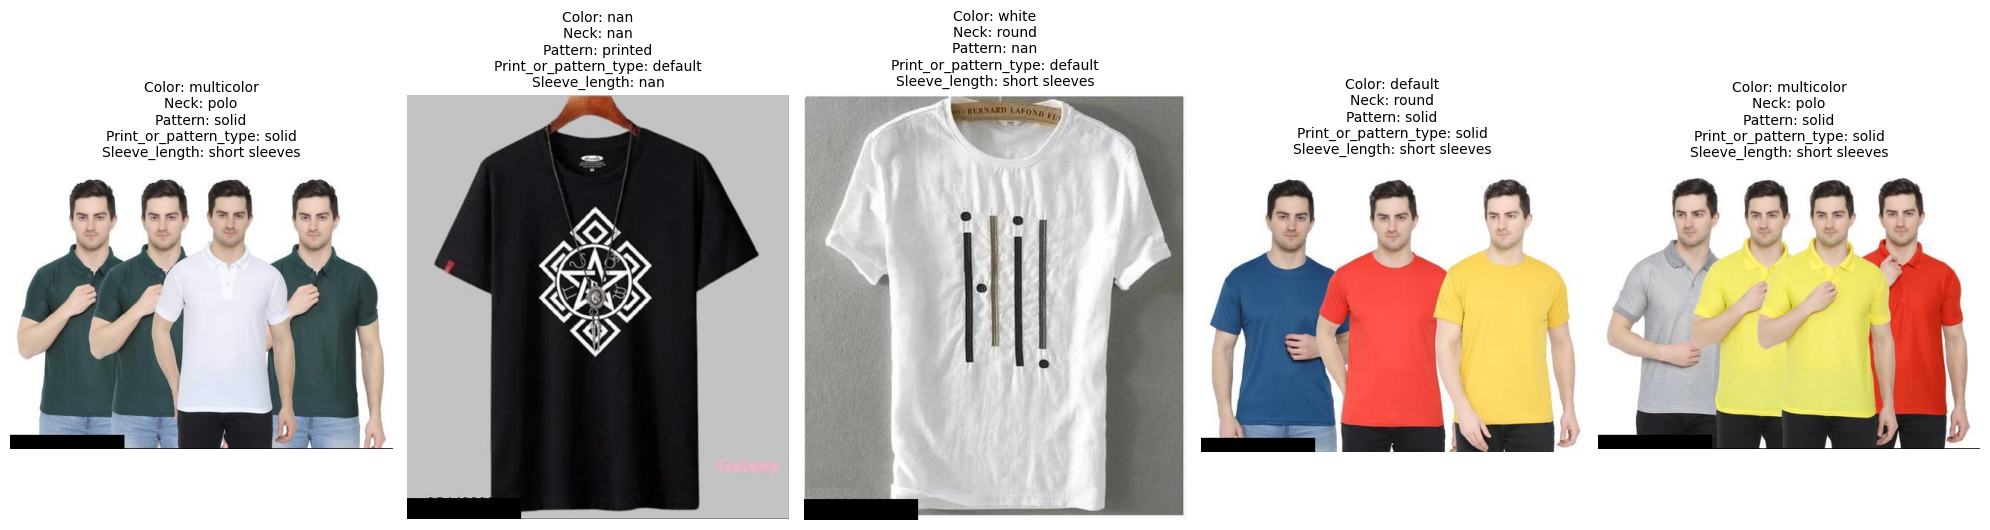

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg

# Sample 5 random images from the DataFrame
sample_df = train_df_cat.sample(5)

# Create subplots to display the images with their labels
fig, axes = plt.subplots(1, 5, figsize=(20, 10))  # 5 images, side by side

# Loop through each image and label
for i, (idx, row) in enumerate(sample_df.iterrows()):
    # Read the image
    img = mpimg.imread(row['image_path'])
    
    # Display the image in the subplot
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off the axis for a cleaner look
    
    # Set the title with the labels
    label = ""
    for attr, renamed_key in rename_dict.items():
        label += f"{renamed_key.capitalize()}: {row[attr]}\n"

    # Remove the last newline character
    label = label.strip()
    axes[i].set_title(label, fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Get value counts for each specified column
columns_of_interest = attr_columns

for column in columns_of_interest:
    print(f"Value counts for {column}:\n")
    print(train_df_cat[column].value_counts(dropna=False))  # Including NaN values
    print("\n" + "-"*50 + "\n")

Value counts for attr_1:

attr_1
default       2132
multicolor    1821
NaN           1257
white         1253
black          804
Name: count, dtype: int64

--------------------------------------------------

Value counts for attr_2:

attr_2
polo     3085
round    3059
NaN      1123
Name: count, dtype: int64

--------------------------------------------------

Value counts for attr_3:

attr_3
solid      3185
printed    2606
NaN        1476
Name: count, dtype: int64

--------------------------------------------------

Value counts for attr_4:

attr_4
solid         3197
default       1971
NaN           1318
typography     781
Name: count, dtype: int64

--------------------------------------------------

Value counts for attr_5:

attr_5
short sleeves    5647
NaN              1290
long sleeves      330
Name: count, dtype: int64

--------------------------------------------------



In [13]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
from torchvision import models, transforms
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Apply Color Jitter
    transforms.RandomHorizontalFlip(),  # Apply Horizontal Flip with 50% probability
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# for attribute in [f'attr_{j+1}' for j in range(10)]:
#     le = LabelEncoder()
#     train_df_cat[attribute] = le.fit_transform(train_df_cat[attribute].astype(str))  # Convert NaNs to 'nan' string for encoding
# #     label_encoders[attribute] = le

In [ ]:
train_df_cat

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,image_path
0,0,Men Tshirts,5,default,round,printed,default,short sleeves,/kaggle/input/visual-taxonomy/train_images/000000.jpg
1,1,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,/kaggle/input/visual-taxonomy/train_images/000001.jpg
2,2,Men Tshirts,5,default,polo,solid,solid,short sleeves,/kaggle/input/visual-taxonomy/train_images/000002.jpg
3,3,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,/kaggle/input/visual-taxonomy/train_images/000003.jpg
4,4,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,/kaggle/input/visual-taxonomy/train_images/000004.jpg
...,...,...,...,...,...,...,...,...,...
7262,7424,Men Tshirts,5,NaN,NaN,printed,NaN,NaN,/kaggle/input/visual-taxonomy/train_images/007424.jpg
7263,7425,Men Tshirts,5,NaN,round,NaN,NaN,NaN,/kaggle/input/visual-taxonomy/train_images/007425.jpg
7264,7426,Men Tshirts,5,NaN,NaN,NaN,default,short sleeves,/kaggle/input/visual-taxonomy/train_images/007426.jpg
7265,7429,Men Tshirts,5,NaN,NaN,NaN,default,NaN,/kaggle/input/visual-taxonomy/train_images/007429.jpg


In [17]:
class ShirtDataset(Dataset):
    def __init__(self, dataframe, attribute, transform=None):
        self.dataframe = dataframe
        self.attribute = attribute
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img = Image.open(row['image_path']).convert("RGB")
        if self.transform:
            img = self.transform(img)
        
        # Get attribute label (NaN values handled by replacing with -1)
        label = row[self.attribute] if not pd.isna(row[self.attribute]) else -1
        return img, label

# Function to train DenseNet for a specific attribute
def train_densenet(df, attribute):
    # Filter rows with non-NaN values for training
    train_df = df[df[attribute].notna()].copy()  # Use only rows with valid labels
#     for attribute in [f'attr_{j+1}' for j in range(10)]:
    le = LabelEncoder()
    train_df[attribute] = le.fit_transform(train_df[attribute].astype(str))  # Convert NaNs to 'nan' string for encoding
#     label_encoders[attribute] = le
    

    # Define dataset and dataloader
    train_dataset = ShirtDataset(train_df, attribute, transform=preprocess)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Load a pre-trained DenseNet model and adjust final layer
    densenet = models.efficientnet_b5(pretrained=True)
    num_features = 2048
    densenet.classifier = nn.Linear(num_features, len(train_df[attribute].unique()))
    densenet = densenet.to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(densenet.parameters(), lr=0.0001)

    # Training loop
    densenet.train()
    for epoch in range(4):  # Use more epochs as needed
        for images, labels in tqdm(train_loader, desc=f"Training {attribute}"):
            images = images.to(device)
            labels = labels.to(device).long()
            
            # Forward pass
            outputs = densenet(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Set model to evaluation mode
    densenet.eval()
    return densenet,le

# Function to impute missing values using the trained DenseNet
def impute_attribute(df, attribute, model,le):
    # Dataset and loader for missing values
    nan_df = df[df[attribute].isna()].copy()  # Select rows with NaN in the attribute
    nan_dataset = ShirtDataset(nan_df, attribute, transform=preprocess)
    nan_loader = DataLoader(nan_dataset, batch_size=32, shuffle=False)

    predictions = []
    with torch.no_grad():
        for images, _ in tqdm(nan_loader, desc=f"Predicting {attribute}"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            predictions_ = le.inverse_transform(np.array(predictions))

    # Fill NaNs with predictions
    df.loc[df[attribute].isna(), attribute] = predictions_
    print(df.info())
    return df

In [ ]:
from tqdm import tqdm

for j in tqdm(range(5)):
    model,le = train_densenet(train_df_cat,f'attr_{j+1}')
    train_df_cat = impute_attribute(train_df_cat,f'attr_{j+1}',model,le)

  0%|          | 0/5 [00:00<?, ?it/s]Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth

  0%|          | 0.00/117M [00:00<?, ?B/s]
  1%|          | 896k/117M [00:00<00:14, 8.65MB/s]
  4%|▎         | 4.38M/117M [00:00<00:04, 24.7MB/s]
 13%|█▎        | 15.4M/117M [00:00<00:01, 65.4MB/s]
 30%|██▉       | 35.0M/117M [00:00<00:00, 120MB/s] 
 49%|████▊     | 56.8M/117M [00:00<00:00, 159MB/s]
 67%|██████▋   | 78.6M/117M [00:00<00:00, 183MB/s]
100%|██████████| 117M/117M [00:00<00:00, 157MB/s]

Training attr_1: 100%|██████████| 188/188 [02:45<00:00,  1.14it/s]

Training attr_1: 100%|██████████| 188/188 [02:22<00:00,  1.32it/s]

Training attr_1: 100%|██████████| 188/188 [02:22<00:00,  1.32it/s]

Training attr_1: 100%|██████████| 188/188 [02:22<00:00,  1.32it/s]

 20%|██        | 1/5 [10:23<41:34, 623.53s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 7267 entries, 0 to 7266
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7267 non-null   int64 
 1   Category    7267 non-null   object
 2   len         7267 non-null   int64 
 3   attr_1      7267 non-null   object
 4   attr_2      6144 non-null   object
 5   attr_3      5791 non-null   object
 6   attr_4      5949 non-null   object
 7   attr_5      5977 non-null   object
 8   image_path  7267 non-null   object
dtypes: int64(2), object(7)
memory usage: 567.7+ KB
None



Training attr_2: 100%|██████████| 192/192 [02:26<00:00,  1.31it/s]

Training attr_2: 100%|██████████| 192/192 [02:25<00:00,  1.32it/s]

Training attr_2: 100%|██████████| 192/192 [02:25<00:00,  1.32it/s]

Training attr_2: 100%|██████████| 192/192 [02:26<00:00,  1.31it/s]

 40%|████      | 2/5 [20:28<30:37, 612.62s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 7267 entries, 0 to 7266
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7267 non-null   int64 
 1   Category    7267 non-null   object
 2   len         7267 non-null   int64 
 3   attr_1      7267 non-null   object
 4   attr_2      7267 non-null   object
 5   attr_3      5791 non-null   object
 6   attr_4      5949 non-null   object
 7   attr_5      5977 non-null   object
 8   image_path  7267 non-null   object
dtypes: int64(2), object(7)
memory usage: 567.7+ KB
None



Training attr_3: 100%|██████████| 181/181 [02:17<00:00,  1.31it/s]

Training attr_3: 100%|██████████| 181/181 [02:17<00:00,  1.32it/s]

Training attr_3: 100%|██████████| 181/181 [02:16<00:00,  1.32it/s]

Training attr_3: 100%|██████████| 181/181 [02:17<00:00,  1.32it/s]

 60%|██████    | 3/5 [30:05<19:52, 596.35s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 7267 entries, 0 to 7266
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7267 non-null   int64 
 1   Category    7267 non-null   object
 2   len         7267 non-null   int64 
 3   attr_1      7267 non-null   object
 4   attr_2      7267 non-null   object
 5   attr_3      7267 non-null   object
 6   attr_4      5949 non-null   object
 7   attr_5      5977 non-null   object
 8   image_path  7267 non-null   object
dtypes: int64(2), object(7)
memory usage: 567.7+ KB
None



Training attr_4: 100%|██████████| 186/186 [02:22<00:00,  1.31it/s]

Training attr_4: 100%|██████████| 186/186 [02:20<00:00,  1.32it/s]

Training attr_4: 100%|██████████| 186/186 [02:21<00:00,  1.32it/s]

Training attr_4: 100%|██████████| 186/186 [02:20<00:00,  1.32it/s]

 80%|████████  | 4/5 [39:55<09:53, 593.87s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 7267 entries, 0 to 7266
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7267 non-null   int64 
 1   Category    7267 non-null   object
 2   len         7267 non-null   int64 
 3   attr_1      7267 non-null   object
 4   attr_2      7267 non-null   object
 5   attr_3      7267 non-null   object
 6   attr_4      7267 non-null   object
 7   attr_5      5977 non-null   object
 8   image_path  7267 non-null   object
dtypes: int64(2), object(7)
memory usage: 567.7+ KB
None



Training attr_5: 100%|██████████| 187/187 [02:22<00:00,  1.31it/s]

Training attr_5: 100%|██████████| 187/187 [02:21<00:00,  1.32it/s]

Training attr_5: 100%|██████████| 187/187 [02:22<00:00,  1.31it/s]

Training attr_5: 100%|██████████| 187/187 [02:21<00:00,  1.32it/s]

100%|██████████| 5/5 [49:48<00:00, 597.71s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 7267 entries, 0 to 7266
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7267 non-null   int64 
 1   Category    7267 non-null   object
 2   len         7267 non-null   int64 
 3   attr_1      7267 non-null   object
 4   attr_2      7267 non-null   object
 5   attr_3      7267 non-null   object
 6   attr_4      7267 non-null   object
 7   attr_5      7267 non-null   object
 8   image_path  7267 non-null   object
dtypes: int64(2), object(7)
memory usage: 567.7+ KB
None


In [ ]:
train_df_cat

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,image_path
0,0,Men Tshirts,5,default,round,printed,default,short sleeves,/kaggle/input/visual-taxonomy/train_images/000000.jpg
1,1,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,/kaggle/input/visual-taxonomy/train_images/000001.jpg
2,2,Men Tshirts,5,default,polo,solid,solid,short sleeves,/kaggle/input/visual-taxonomy/train_images/000002.jpg
3,3,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,/kaggle/input/visual-taxonomy/train_images/000003.jpg
4,4,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,/kaggle/input/visual-taxonomy/train_images/000004.jpg
...,...,...,...,...,...,...,...,...,...
7262,7424,Men Tshirts,5,black,round,printed,default,short sleeves,/kaggle/input/visual-taxonomy/train_images/007424.jpg
7263,7425,Men Tshirts,5,default,round,printed,default,long sleeves,/kaggle/input/visual-taxonomy/train_images/007425.jpg
7264,7426,Men Tshirts,5,white,round,printed,default,short sleeves,/kaggle/input/visual-taxonomy/train_images/007426.jpg
7265,7429,Men Tshirts,5,black,round,printed,default,short sleeves,/kaggle/input/visual-taxonomy/train_images/007429.jpg


In [ ]:
train_df_cat['attr_1'].isnull().sum()

0

In [ ]:
train_df_cat.to_csv('output/train_fillna_Men_Tshirts_effnet_b5_4epochs.csv',index=False)

In [ ]:
# from tqdm import tqdm

# for j in tqdm(range(10)):
#     train_df_cat = impute_attribute(train_df_cat,f'attr_{j+1}')